In [15]:
from utils5 import *

## Exhaustive

In [ ]:
import networkx as nx
from networkx.algorithms import isomorphism
from tqdm.notebook import tqdm

def is_new_graph_isomorphic(G, unique_graphs):
    """
    Check if G is isomorphic to any graph in unique_graphs using NetworkX's is_isomorphic.
    Returns True if an isomorphism is found, else False.
    """
    for UG in unique_graphs:
        if nx.is_isomorphic(G, UG):
            return True
    return False

def has_cycle_dfs(adjacency):
    """
    Return True if 'adjacency' has a cycle, otherwise False.
    adjacency[u] is the list of children of node u.
    """
    n = len(adjacency)
    visited = [0]*n  # 0=unvisited, 1=visiting, 2=finished
    
    def dfs(u):
        if visited[u] == 1:  # found back-edge => cycle
            return True
        if visited[u] == 2:
            return False
        visited[u] = 1
        for v in adjacency[u]:
            if dfs(v):
                return True
        visited[u] = 2
        return False
    
    for node in range(n):
        if visited[node] == 0:
            if dfs(node):
                return True
    return False

def build_nx_digraph_from_adjacency(adjacency):
    """
    Create a NetworkX DiGraph from the adjacency list.
    """
    G = nx.DiGraph()
    n = len(adjacency)
    G.add_nodes_from(range(n))
    for u in range(n):
        for v in adjacency[u]:
            G.add_edge(u, v)
    return G

def generate_dags_with_constraints_connected(num_internal_nodes=1, k=2):
    """
    Recursively generate DAGs with:
      1) 4 fixed sources: nodes [0,1,2,3] => in-degree=0
      2) Exactly 1 sink: node n-1 => out-degree=0, exactly 1 incoming edge
      3) All other nodes must have out_degree>0 (no other sink)
      4) in-degree <= 2 for every node
      5) out-degree <= k for every node
      6) no cycles
      7) all nodes must be weakly connected in undirected sense
      8) n = 5 + num_internal_nodes

    Returns a list of unique NetworkX DiGraphs (pruned by isomorphism).
    Shows a tqdm progress bar in a Jupyter notebook that accounts for pruned subtrees.
    """
    n = num_internal_nodes + 5

    # adjacency[u] = list of children of u
    adjacency = [[] for _ in range(n)]
    in_degree = [0]*n
    out_degree = [0]*n

    # We won't add edges into sources [0..3], or out of sink [n-1].
    possible_edges = []
    for i in range(n-1):  # skip i = n-1 (the sink)
        for j in range(i+1, n):
            if 0 <= j <= 3:
                # skip edges into the 4 sources
                continue
            possible_edges.append((i, j))
    
    unique_graphs = []

    # We'll have 2^(len(possible_edges)) total subsets in the worst case
    total_subsets = 2 ** len(possible_edges)

    progress_bar = tqdm(total=total_subsets, desc="Generating DAGs (connected)")

    def backtrack(edge_index):
        """Recursive backtracking over each edge decision: skip or add."""
        if edge_index == len(possible_edges):
            # We've assigned all possible edges => this is one "leaf" subset
            progress_bar.update(1)
            
            # 1) sink n-1 must have exactly 1 incoming edge
            if in_degree[n-1] != 1:
                return
            # 2) no cycles
            if has_cycle_dfs(adjacency):
                return
            
            # 3) Build Nx DiGraph
            G = build_nx_digraph_from_adjacency(adjacency)
            
            # 4) Check weak connectivity
            if not nx.is_weakly_connected(G):
                return
            
            # 5) Ensure no other node is a sink => out_degree[node] > 0 for node in [0..n-2]
            for node in range(n-1):
                if out_degree[node] == 0:
                    return
            
            # 6) Prune isomorphs
            if not is_new_graph_isomorphic(G, unique_graphs):
                unique_graphs.append(G)
            return
        
        (u, v) = possible_edges[edge_index]
        remaining_edges = len(possible_edges) - edge_index - 1

        # Option A: skip this edge
        backtrack(edge_index + 1)
        
        # Option B: add the edge, if constraints allow
        if in_degree[v] < 2 and out_degree[u] < k:
            adjacency[u].append(v)
            in_degree[v] += 1
            out_degree[u] += 1
            
            # Early cycle check
            if has_cycle_dfs(adjacency):
                # prune entire subtree
                progress_bar.update(2 ** remaining_edges)
            else:
                backtrack(edge_index + 1)
            
            # revert
            adjacency[u].pop()
            in_degree[v] -= 1
            out_degree[u] -= 1
        else:
            # can't add => skip that entire subtree
            progress_bar.update(2 ** remaining_edges)

    backtrack(0)
    progress_bar.close()
    return unique_graphs

In [ ]:
graphs = generate_dags_with_constraints_connected(num_internal_nodes=5, k=4)
print(f"Generated {len(graphs)} connected DAGs.")


In [ ]:
import os
import networkx as nx

# Create a directory to store the graphs if it doesn't exist
os.makedirs("4_input_precomputed_graphs", exist_ok=True)

with open("4_input_precomputed_graphs/4_input_precomputed_graphs_5_nodes_k_4.pkl", "wb") as f:
    pickle.dump(graphs, f)
    
print("Graphs have been saved.")


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_generated_dags(graphs, n=25, use_dot_layout=True):
    """
    Plots the first `n` DAGs from the given list of NetworkX DiGraphs using NetworkX's drawing utilities.

    - Uses Graphviz's 'dot' layout if available (ensures top-down flow).
    - Falls back to NetworkX's `spring_layout` if Graphviz is not available.
    - Arranges graphs in a grid automatically.

    :param graphs: List of NetworkX DiGraphs
    :param n: Number of graphs to plot (default: 5)
    :param use_dot_layout: Whether to use Graphviz's 'dot' layout if available (default: True)
    """
    num_graphs = min(n, len(graphs))
    if num_graphs == 0:
        print("No graphs to display.")
        return

    # Determine grid layout
    rows = int(num_graphs ** 0.5) + 1
    cols = (num_graphs // rows) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten() if rows * cols > 1 else [axes]

    for i in range(num_graphs):
        G = graphs[i]
        ax = axes[i]

        # Use Graphviz's 'dot' layout if available, else fallback to spring_layout
        if use_dot_layout:
            try:
                pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="dot")
            except ImportError:
                print("Graphviz not available, falling back to spring layout.")
                pos = nx.spring_layout(G)
        else:
            pos = nx.spring_layout(G)

        # Draw the graph using NetworkX
        nx.draw(G, pos, with_labels=True, node_size=100, node_color="lightblue", 
                edge_color="gray", arrows=True, ax=ax, font_size=10)
        
        ax.set_title(f"Graph {i+1}")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# Plot the first 5 generated DAGs
plot_generated_dags(graphs, n=5)

In [ ]:
graphs_4_gates = generate_dags_with_constraints_connected(num_internal_nodes=4, k=4)
print(f"Generated {len(graphs_4_gates)} connected DAGs.")

In [ ]:
# Plot the first 5 generated DAGs
plot_generated_dags(graphs_4_gates, n=5)

In [ ]:
with open("4_input_precomputed_graphs/4_input_precomputed_graphs_4_nodes_k_4.pkl", "wb") as f:
    pickle.dump(graphs_4_gates, f)
    
print("Graphs have been saved.")

In [ ]:
graphs_3_gates = generate_dags_with_constraints_connected(num_internal_nodes=3, k=4)
print(f"Generated {len(graphs_3_gates)} connected DAGs.")

In [ ]:
# Plot the first 5 generated DAGs
plot_generated_dags(graphs_3_gates, n=5)

In [ ]:
with open("4_input_precomputed_graphs/4_input_precomputed_graphs_3_nodes_k_4.pkl", "wb") as f:
    pickle.dump(graphs_3_gates, f)
    
print("Graphs have been saved.")

## Randomized 

In [ ]:
import random
import networkx as nx
from tqdm.notebook import tqdm

def is_new_graph_isomorphic(G, unique_graphs):
    """
    Check if G is isomorphic to any graph in unique_graphs using NetworkX's is_isomorphic.
    Returns True if an isomorphism is found, else False.
    """
    from networkx.algorithms import isomorphism
    for UG in unique_graphs:
        if isomorphism.is_isomorphic(G, UG):
            return True
    return False

def has_cycle_dfs(adjacency):
    """
    Return True if 'adjacency' has a cycle, otherwise False.
    adjacency[u] is the list of children of node u.
    """
    n = len(adjacency)
    visited = [0]*n  # 0=unvisited, 1=visiting, 2=finished
    
    def dfs(u):
        if visited[u] == 1:  # found back-edge => cycle
            return True
        if visited[u] == 2:
            return False
        visited[u] = 1
        for v in adjacency[u]:
            if dfs(v):
                return True
        visited[u] = 2
        return False
    
    for node in range(n):
        if visited[node] == 0:
            if dfs(node):
                return True
    return False

def build_nx_digraph_from_adjacency(adjacency):
    """
    Create a NetworkX DiGraph from the adjacency list.
    """
    G = nx.DiGraph()
    n = len(adjacency)
    G.add_nodes_from(range(n))
    for u in range(n):
        for v in adjacency[u]:
            G.add_edge(u, v)
    return G

'''
# This older function does not check that all nodes have at least 1 incoming edge
# leading to a small number of cases where graphs have more than 4 inputs
def sample_dags_with_constraints_strict(
    num_internal_nodes=1, 
    k=2, 
    sample_size=5, 
    max_tries=10000, 
    p=0.5
):
    """
    Generate a *random sample* of DAGs that satisfy:
      1) 4 fixed sources: nodes [0..3] => in-degree=0.
      2) Exactly 1 sink: node (n-1) => out-degree=0, exactly 1 incoming edge.
      3) No other node is a sink => out_degree(u) > 0 for all u in [0..n-2].
      4) in-degree(u) <= 2, out_degree(u) <= k
      5) Acyclic
      6) Weakly connected
      7) total nodes = 5 + num_internal_nodes

    We do *rejection sampling* by randomly choosing edges with probability p,
    while enforcing single-sink constraints.

    PROGRESS BAR:
      - Tracks how many *attempts* we've used out of max_tries, so 100% means
        we've exhausted all attempts (not necessarily that we have sample_size DAGs).

    :param num_internal_nodes: number of internal nodes (besides 4 sources & 1 sink)
    :param k: max fan-out
    :param sample_size: how many DAGs to collect
    :param max_tries: how many random attempts
    :param p: probability of choosing each allowed edge
    :return: list of unique NetworkX DiGraphs
    """
    n = 5 + num_internal_nodes  # total nodes
    sink = n - 1

    # Build the list of possible edges:
    # skip edges into the 4 sources [0..3], skip edges out of the sink (n-1).
    possible_edges = []
    for i in range(n-1):  # i in [0..n-2]
        for j in range(i+1, n):
            if 0 <= j <= 3:
                # skip edges into [0..3]
                continue
            # by limiting i < n-1, we skip edges from sink
            possible_edges.append((i, j))

    unique_graphs = []

    # Progress bar: total is max_tries, meaning 100% = we used all attempts
    with tqdm(total=max_tries, desc="Random DAG sampling (attempts)") as pbar:
        attempts = 0
        while len(unique_graphs) < sample_size and attempts < max_tries:
            attempts += 1
            pbar.update(1)  # one more attempt

            # 1) Start an empty adjacency
            adjacency = [[] for _ in range(n)]
            in_degree = [0]*n
            out_degree = [0]*n
            in_degree_sink = 0  # track how many edges into sink

            # Shuffle edges
            edges_shuffled = list(possible_edges)
            random.shuffle(edges_shuffled)

            for (u, v) in edges_shuffled:
                # If the sink already has exactly 1 incoming edge, skip more edges into it
                if v == sink and in_degree_sink >= 1:
                    continue

                if random.random() < p:
                    if in_degree[v] < 2 and out_degree[u] < k:
                        adjacency[u].append(v)
                        in_degree[v] += 1
                        out_degree[u] += 1
                        if v == sink:
                            in_degree_sink += 1

                        # If cycle, revert
                        if has_cycle_dfs(adjacency):
                            adjacency[u].pop()
                            in_degree[v] -= 1
                            out_degree[u] -= 1
                            if v == sink:
                                in_degree_sink -= 1

            # 2) Final checks
            # (a) sources [0..3] => in_degree=0
            if any(in_degree[i] != 0 for i in [0,1,2,3]):
                continue

            # (b) sink => out_degree[sink]==0, exactly 1 incoming edge
            if out_degree[sink] != 0 or in_degree[sink] != 1:
                continue

            # (c) No other node is sink => out_degree(u)>0 for [0..n-2]
            for node in range(n-1):
                if out_degree[node] == 0:
                    break
            else:
                # only proceed if we didn't break
                # (d) in_degree(u)<=2, out_degree(u)<=k
                valid = True
                for node in range(n):
                    if in_degree[node] > 2 or out_degree[node] > k:
                        valid = False
                        break
                if not valid:
                    continue

                # (e) no cycles
                if has_cycle_dfs(adjacency):
                    continue

                # (f) weakly connected
                G_temp = build_nx_digraph_from_adjacency(adjacency)
                if not nx.is_weakly_connected(G_temp):
                    continue

                # If we reach here => DAG is valid
                if not is_new_graph_isomorphic(G_temp, unique_graphs):
                    unique_graphs.append(G_temp)

    return unique_graphs
'''

def sample_dags_with_constraints_strict(
    num_internal_nodes=1, 
    k=2, 
    sample_size=5, 
    max_tries=10000, 
    p=0.5
):
    n = 5 + num_internal_nodes  # total nodes
    sink = n - 1

    # Build the list of possible edges:
    possible_edges = []
    for i in range(n-1):  # i in [0..n-2]
        for j in range(i+1, n):
            if 0 <= j <= 3:
                # skip edges into [0..3]
                continue
            possible_edges.append((i, j))

    unique_graphs = []

    with tqdm(total=max_tries, desc="Random DAG sampling (attempts)") as pbar:
        attempts = 0
        while len(unique_graphs) < sample_size and attempts < max_tries:
            attempts += 1
            pbar.update(1)

            adjacency = [[] for _ in range(n)]
            in_degree = [0]*n
            out_degree = [0]*n
            in_degree_sink = 0

            edges_shuffled = list(possible_edges)
            random.shuffle(edges_shuffled)

            for (u, v) in edges_shuffled:
                if v == sink and in_degree_sink >= 1:
                    continue

                if random.random() < p:
                    if in_degree[v] < 2 and out_degree[u] < k:
                        adjacency[u].append(v)
                        in_degree[v] += 1
                        out_degree[u] += 1
                        if v == sink:
                            in_degree_sink += 1

                        if has_cycle_dfs(adjacency):
                            adjacency[u].pop()
                            in_degree[v] -= 1
                            out_degree[u] -= 1
                            if v == sink:
                                in_degree_sink -= 1

            # (a) Ensure fixed sources [0..3] have in_degree 0
            if any(in_degree[i] != 0 for i in [0,1,2,3]):
                continue

            # NEW CHECK: Ensure no extra sources exist beyond nodes 0..3.
            # Only nodes 0,1,2,3 should have in_degree==0.
            sources = [i for i in range(n) if in_degree[i] == 0]
            if set(sources) != set(range(4)):
                continue

            # (b) Check sink: exactly 1 incoming edge and no outgoing edges
            if out_degree[sink] != 0 or in_degree[sink] != 1:
                continue

            # (c) Check that no other node is a sink: out_degree(u) > 0 for u in [0..n-2]
            for node in range(n-1):
                if out_degree[node] == 0:
                    break
            else:
                valid = True
                for node in range(n):
                    if in_degree[node] > 2 or out_degree[node] > k:
                        valid = False
                        break
                if not valid:
                    continue

                if has_cycle_dfs(adjacency):
                    continue

                G_temp = build_nx_digraph_from_adjacency(adjacency)
                if not nx.is_weakly_connected(G_temp):
                    continue

                if not is_new_graph_isomorphic(G_temp, unique_graphs):
                    unique_graphs.append(G_temp)

    return unique_graphs


In [ ]:
# Suppose we want 5 random DAGs with 1 internal node (total n=6),
# out-degree <= 2, 10,000 tries max, each edge chosen with probability 0.4:
sampled_graphs = sample_dags_with_constraints_strict(
    num_internal_nodes=6,
    k = 4,
    sample_size=10000,
    max_tries=100000000,
    p=0.9
)

print(f"Found {len(sampled_graphs)} unique random DAGs.")



In [ ]:
# Plot the first 5 DAGs using NetworkX layouts  
plot_generated_dags(sampled_graphs, n=10)

### Add labels to inputs and outputs

In [ ]:
def add_io_attributes(graphs):
    """
    For each graph in `graphs`, add a node attribute "type":
      - "input" for nodes with in-degree=0
      - "output" for nodes with out-degree=0
    If a node is neither, we leave its type unset (or you could set "type":"internal").
    """
    for G in graphs:
        # For each node, check in_degree and out_degree
        for node in G.nodes():
            if G.in_degree(node) == 0:
                G.nodes[node]["type"] = "input"
            elif G.out_degree(node) == 0:
                G.nodes[node]["type"] = "output"
            else:
                # Optionally mark everything else as "internal"
                # G.nodes[node]["type"] = "internal"
                pass


In [ ]:
add_io_attributes(sampled_graphs)

In [ ]:
calculate_truth_table_v2(sampled_graphs[0])

In [ ]:
# Example function to print node attributes
def print_node_attributes(G):
    for node, attrs in G.nodes(data=True):
        print(f"Node: {node}, Attributes: {attrs}")
        
print_node_attributes(sampled_graphs[0])      

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

# Assuming extended_dags_4_gates is your list or dictionary of NetworkX graphs
graphs_list = sampled_graphs

# Determine the total number of graphs to plot (min between 48 and the length of the collection)
total_to_plot = min(48, len(graphs_list))
sampled_graphs
# Randomly select graphs
selected_graphs = random.sample(graphs_list, total_to_plot)

# Define the grid layout
n_cols = 8
n_rows = 6  # Since we want to plot 8*6 graphs specifically

# Set the overall figure size
fig_size_width = n_cols * 1.5
fig_size_height = n_rows * 1.5
plt.figure(figsize=(fig_size_width, fig_size_height))

# Plot each of the randomly selected graphs
for i, G in enumerate(selected_graphs, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    pos = nx.spring_layout(G)  # Calculate positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50,
            edge_color='k', linewidths=0.5, font_size=6,
            arrows=True, arrowsize=5, ax=ax)
    ax.set_title(f"Graph {i}", fontsize=8)  # Set a title for each subplot

plt.tight_layout()
plt.show()

### Permute inputs and organize by truth table 

In [ ]:
import itertools
import networkx as nx
from tqdm.notebook import tqdm

def is_graph_isomorphic(new_graph, existing_graph_ids, all_graphs):
    """
    Check if 'new_graph' is isomorphic to any graph in the list 'existing_graph_ids'.
    'all_graphs' is a list of all graphs loaded from pickle, where the index is the ID.
    """
    for g_id in existing_graph_ids:
        candidate_graph = all_graphs[g_id]
        if nx.is_isomorphic(new_graph, candidate_graph):
            return True
    return False

def permute_graph_inputs(graph, input_nodes, permutation):
    """
    Given a DAG and a permutation of its input nodes, return a new graph
    where the input nodes are relabeled accordingly.
    
    :param graph: NetworkX DiGraph
    :param input_nodes: List of input nodes
    :param permutation: Permutation of input nodes
    :return: A new NetworkX DiGraph with input nodes relabeled
    """
    mapping = dict(zip(input_nodes, permutation))
    return nx.relabel_nodes(graph, mapping, copy=True)

def generate_permuted_graphs(graphs_library):
    """
    For each DAG in `graphs_library`, generate all possible input permutations.
    - Only permutes nodes labeled as "input".
    - Skips identity permutations to avoid redundant graphs.
    - Adds new permuted graphs to the library.
    
    :param graphs_library: Dictionary { graph_id -> NetworkX DiGraph }
    :return: Updated graphs_library with permuted graphs added.
    """
    # Get initial keys (avoid iterating over newly added graphs)
    original_keys = sorted(graphs_library.keys())
    next_key = max(original_keys) + 1  # Track next available graph ID

    for graph_id in tqdm(original_keys, desc="Permuting graphs"):
        graph = graphs_library[graph_id]

        # Identify all input nodes (assuming they have type='input')
        input_nodes = [n for n, d in graph.nodes(data=True) if d.get('type') == 'input']

        # Generate all permutations of input nodes
        for permutation in itertools.permutations(input_nodes):
            if permutation == tuple(input_nodes):
                continue  # Skip identity permutation
            
            new_graph = permute_graph_inputs(graph, input_nodes, permutation)
            
            # Store the new permuted graph
            graphs_library[next_key] = new_graph
            next_key += 1

    return graphs_library

def classify_graphs_by_truth_table(graphs_library, calculate_truth_table, truth_table_to_index, is_graph_isomorphic):
    """
    Classifies graphs by their computed truth table.
    
    :param graphs_library: Dictionary { graph_id -> NetworkX DiGraph }
    :param calculate_truth_table: Function that computes the truth table of a graph
    :param truth_table_to_index: Function that converts a truth table to a unique index
    :param is_graph_isomorphic: Function to check if a new graph is isomorphic to existing graphs
    :return: Dictionary { truth_table_index -> list of graph IDs }
    """
    precomputed_graphs = {}  # { truth_table_index -> list of graph IDs }

    pbar_classify = tqdm(total=len(graphs_library), desc="Classifying graphs")
    for graph_id, G in graphs_library.items():
        truth_table = calculate_truth_table(G)
        truth_table_index = truth_table_to_index(truth_table)

        if truth_table_index not in precomputed_graphs:
            precomputed_graphs[truth_table_index] = [graph_id]
        else:
            existing_ids = precomputed_graphs[truth_table_index]
            if not is_graph_isomorphic(G, existing_ids, graphs_library):
                existing_ids.append(graph_id)

        pbar_classify.update(1)
    
    pbar_classify.close()
    return precomputed_graphs

# Usage Example (Assuming you have truth table functions)
# sampled_graphs should already have 'type' attributes set.
graphs_library = {i: G for i, G in enumerate(sampled_graphs)}

# Step 1: Generate permuted graphs
graphs_library_permuted = generate_permuted_graphs(graphs_library)

# Step 2: Classify graphs by truth table (functions must be provided)
precomputed_graphs = classify_graphs_by_truth_table(
    graphs_library_permuted,
    calculate_truth_table,   # User-defined function
    truth_table_to_index,    # User-defined function
    is_graph_isomorphic      # User-defined function
)

print("Finished classifying graphs by truth table!")
print("Number of unique truth table classes:", len(precomputed_graphs))


### Generate 4-input library

In [ ]:
# Exhaustive 1, 2, 3, 4, 5 gates (take about 1 hour)

graphs_3_gates = generate_dags_with_constraints_connected(num_internal_nodes=3, k=4)
print(f"Generated {len(graphs_3_gates)} connected DAGs.")

In [ ]:
graphs_4_gates = generate_dags_with_constraints_connected(num_internal_nodes=4, k=4)
print(f"Generated {len(graphs_4_gates)} connected DAGs.")

In [ ]:
graphs_5_gates = generate_dags_with_constraints_connected(num_internal_nodes=5, k=4)
print(f"Generated {len(graphs_4_gates)} connected DAGs.")

In [ ]:
graphs_5_gates_random = sample_dags_with_constraints_strict(
    num_internal_nodes=5,
    k = 4,
    sample_size=10000,
    max_tries=1000000,
    p=0.9
)

print(f"Found {len(graphs_5_gates_random)} unique random DAGs.")


In [ ]:
with open("4_input_precomputed_graphs/4_input_precomputed_graphs_5_nodes_random_k_4.pkl", "wb") as f:
    pickle.dump(graphs_5_gates_random, f)
    
print("Graphs have been saved.")

In [ ]:
# Randomized for 6, 7, 8, 9, 10 gates 

In [ ]:
graphs_6_gates = sample_dags_with_constraints_strict(
    num_internal_nodes=6,
    k = 4,
    sample_size=10000,
    max_tries=100000000,
    p=0.9
)

print(f"Found {len(graphs_6_gates)} unique random DAGs.")



In [ ]:
with open("4_input_precomputed_graphs/4_input_precomputed_graphs_6_nodes_k_4.pkl", "wb") as f:
    pickle.dump(graphs_6_gates, f)
    
print("Graphs have been saved.")

In [ ]:
graphs_7_gates = sample_dags_with_constraints_strict(
    num_internal_nodes=7,
    k = 4,
    sample_size=10000,
    max_tries=100000000,
    p=0.9
)

print(f"Found {len(graphs_7_gates)} unique random DAGs.")

In [ ]:
with open("4_input_precomputed_graphs/4_input_precomputed_graphs_7_nodes_k_4.pkl", "wb") as f:
    pickle.dump(graphs_7_gates, f)
    
print("Graphs have been saved.")

In [ ]:
graphs_8_gates = sample_dags_with_constraints_strict(
    num_internal_nodes=8,
    k = 4,
    sample_size=10000,
    max_tries=100000000,
    p=0.9
)

print(f"Found {len(graphs_8_gates)} unique random DAGs.")

In [ ]:
with open("4_input_precomputed_graphs/4_input_precomputed_graphs_8_nodes_k_4.pkl", "wb") as f:
    pickle.dump(graphs_8_gates, f)
    
print("Graphs have been saved.")

In [ ]:
# Join all graphs 

In [ ]:
joint_graphs = graphs_3_gates + graphs_4_gates + graphs_6_gates + graphs_7_gates

In [ ]:
# Organize by truth table 
'''
Get first graph, permute inputs, compute truth table using calculate_truth_table_v2, add organize by truth table 

Get the next graph, permute inputs, compute truth table using calculate_truth_table_v2, organize by truth table
but only if it is not isomorphic to graphs for the same truth table. 
'''



In [ ]:
import itertools
import networkx as nx
from tqdm.notebook import tqdm

# ----------------------------------------------------------------
# Placeholder helper functions that you presumably already have:
# You must define or import these according to your own logic.
# ----------------------------------------------------------------


def truth_table_to_index(truth_table):
    # Converts truth table outputs to a binary number, then to decimal
    binary_string = ''.join(str(output[0]) for output in truth_table.values())  # Assumes single output node
    return int(binary_string, 2)

def permute_graph_inputs(graph, original_inputs, permutation):
    """
    Relabel 'original_inputs' in 'graph' according to 'permutation'.
    Produces a new, copied DiGraph with the renamed nodes.
    """
    mapping = dict(zip(original_inputs, permutation))
    return nx.relabel_nodes(graph, mapping, copy=True)

def is_graph_isomorphic(new_graph, existing_graph_ids, graphs_library):
    """
    Check if 'new_graph' is isomorphic to any graph in 'graphs_library'
    whose IDs are listed in 'existing_graph_ids'.
    """
    for gid in existing_graph_ids:
        candidate = graphs_library[gid]
        if nx.is_isomorphic(new_graph, candidate):
            return True
    return False

# ----------------------------------------------------------------
# The main function: 
# Generates permutations one-by-one, computes truth tables, updates 
# the original graphs_library_4_input, and builds precomputed_graphs_4_input.
# ----------------------------------------------------------------

def expand_and_precompute_graphs_library_4_input(graphs_library_4_input):
    """
    1) For each graph in 'graphs_library_4_input', generate input permutations one by one.
    2) Compute truth table (via calculate_truth_table_v2).
    3) Organize by truth table in 'precomputed_graphs_4_input'.
    4) If the new permuted graph is not isomorphic to any already in that truth-table bucket, 
       add it to 'graphs_library_4_input' under a new ID, and record the ID in that bucket.
    
    :param graphs_library_4_input: dict of { graph_id: nx.DiGraph(...) }
    :return: (updated_graphs_library, precomputed_graphs_4_input)
    """
    # Dictionary keyed by truth_table_index => list of graph IDs
    precomputed_graphs_4_input = {}

    # Freeze the list of current graph IDs (so we only permute the *original* set).
    original_graph_ids = sorted(graphs_library_4_input.keys())

    # Track the next available ID for newly added permuted graphs
    next_id = max(original_graph_ids) if original_graph_ids else 0

    # Go through each graph (by ID) in the original library
    for graph_id in tqdm(original_graph_ids, desc="Expanding Graphs"):
        G = graphs_library_4_input[graph_id]
        
        # Identify the input nodes (assuming each input node has attribute 'type'='input')
        input_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'input']

        # Generate permutations of these input nodes
        for permutation in itertools.permutations(input_nodes):
            # (Optional) If you prefer skipping the identity permutation:
            # if permutation == tuple(input_nodes):
            #     continue

            # Create the new permuted graph
            permuted_graph = permute_graph_inputs(G, input_nodes, permutation)

            # Compute the truth table
            tt = calculate_truth_table_v2(permuted_graph)
            tt_index = truth_table_to_index(tt)

            # Ensure there's a bucket for this truth table
            if tt_index not in precomputed_graphs_4_input:
                precomputed_graphs_4_input[tt_index] = []

            # Check isomorphism with existing graphs in this truth-table bucket
            if not is_graph_isomorphic(permuted_graph, precomputed_graphs_4_input[tt_index], graphs_library_4_input):
                # Assign a new ID for the permuted graph
                next_id += 1
                new_graph_id = next_id

                # Store the new graph in the main library
                graphs_library_4_input[new_graph_id] = permuted_graph

                # Add this new graph's ID to the truth-table bucket
                precomputed_graphs_4_input[tt_index].append(new_graph_id)

    # Return both updated structures
    return graphs_library_4_input, precomputed_graphs_4_input

# -----------------------------
# Example usage
# -----------------------------
# Convert sampled_graphs (list) into a dictionary
graphs_library_4_input = {i: G for i, G in enumerate(joint_graphs, start=1)}

# Now expand with permutations, build precomputed dictionary:
updated_graphs_library, precomputed_graphs_4_input = expand_and_precompute_graphs_library_4_input(graphs_library_4_input)




In [ ]:
len(precomputed_graphs_4_input)

In [ ]:
precomputed_graphs_4_input

### Combining the library

In [ ]:
import pickle

# Load graphs_library_4_input_ABC
with open('4_input_precomputed_graphs/4_input_precomputed_graphs_3_nodes_k_4.pkl', 'rb') as file:
    graphs_library_4_input_precomputed_graphs_3_nodes_k_4 = pickle.load(file)

# Verify the loaded data
print(type(graphs_library_4_input_precomputed_graphs_3_nodes_k_4))  # Should be a dict
print(len(graphs_library_4_input_precomputed_graphs_3_nodes_k_4))  # Number of elements in the dictionary

In [ ]:
# Load graphs_library_4_input_ABC
with open('4_input_precomputed_graphs/4_input_precomputed_graphs_4_nodes_k_4.pkl', 'rb') as file:
    graphs_library_4_input_precomputed_graphs_4_nodes_k_4 = pickle.load(file)

# Verify the loaded data
print(type(graphs_library_4_input_precomputed_graphs_4_nodes_k_4))  # Should be a dict
print(len(graphs_library_4_input_precomputed_graphs_4_nodes_k_4))  # Number of elements in the dictionary

In [ ]:
# Load graphs_library_4_input_ABC
with open('4_input_precomputed_graphs/4_input_precomputed_graphs_5_nodes_random_k_4.pkl', 'rb') as file:
    graphs_library_4_input_precomputed_graphs_5_nodes_random_k_4 = pickle.load(file)

# Verify the loaded data
print(type(graphs_library_4_input_precomputed_graphs_5_nodes_random_k_4))  # Should be a dict
print(len(graphs_library_4_input_precomputed_graphs_5_nodes_random_k_4))  # Number of elements in the dictionary

In [ ]:
# Load graphs_library_4_input_ABC
with open('4_input_precomputed_graphs/4_input_precomputed_graphs_6_nodes_k_4.pkl', 'rb') as file:
    graphs_library_4_input_precomputed_graphs_6_nodes_k_4 = pickle.load(file)

# Verify the loaded data
print(type(graphs_library_4_input_precomputed_graphs_6_nodes_k_4))  # Should be a dict
print(len(graphs_library_4_input_precomputed_graphs_6_nodes_k_4))  # Number of elements in the dictionary

In [ ]:
# Load graphs_library_4_input_ABC
with open('4_input_precomputed_graphs/4_input_precomputed_graphs_7_nodes_k_4.pkl', 'rb') as file:
    graphs_library_4_input_precomputed_graphs_7_nodes_k_4 = pickle.load(file)

# Verify the loaded data
print(type(graphs_library_4_input_precomputed_graphs_7_nodes_k_4))  # Should be a dict
print(len(graphs_library_4_input_precomputed_graphs_7_nodes_k_4))  # Number of elements in the dictionary

In [ ]:
# Load graphs_library_4_input_ABC
with open('4_input_precomputed_graphs/4_input_precomputed_graphs_8_nodes_k_4.pkl', 'rb') as file:
    graphs_library_4_input_precomputed_graphs_8_nodes_k_4 = pickle.load(file)

# Verify the loaded data
print(type(graphs_library_4_input_precomputed_graphs_8_nodes_k_4))  # Should be a dict
print(len(graphs_library_4_input_precomputed_graphs_8_nodes_k_4))  # Number of elements in the dictionary

In [ ]:
# Load graphs_library_4_input_ABC
with open('4_input_precomputed_graphs/graphs_library_4_input_ABC.pkl', 'rb') as file:
    graphs_library_4_input_ABC = pickle.load(file)

# Verify the loaded data
print(type(graphs_library_4_input_ABC))  # Should be a dict
print(len(graphs_library_4_input_ABC))  # Number of elements in the dictionary

In [ ]:
calculate_truth_table_v2(graphs_library_4_input_ABC[16])

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = graphs_library_4_input_precomputed_graphs_8_nodes_k_4[200]

for node, attrs in G.nodes(data=True):
    print(f"Node {node}: {attrs}")
    
pos = nx.spring_layout(G)  # Layout for better visualization

plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=12)
plt.show()    

In [ ]:
calculate_truth_table_v2(G)

In [ ]:
# Print the keys (indices)
print(list(graphs_library_4_input_ABC.keys()))


In [ ]:
len(graphs_library_4_input_ABC)

In [ ]:
# Example lists of NetworkX graphs
list1 = graphs_library_4_input_precomputed_graphs_3_nodes_k_4
list2 = graphs_library_4_input_precomputed_graphs_4_nodes_k_4
list3 = graphs_library_4_input_precomputed_graphs_5_nodes_random_k_4
list4 = graphs_library_4_input_precomputed_graphs_6_nodes_k_4
list5 = graphs_library_4_input_precomputed_graphs_7_nodes_k_4
list6 = graphs_library_4_input_precomputed_graphs_8_nodes_k_4



#### Check for any graphs with more than 4 source nodes

In [ ]:
import networkx as nx

# Define a helper function to count the source nodes in a graph
def count_source_nodes(graph):
    # Count nodes with in-degree 0
    return sum(1 for node in graph.nodes() if graph.in_degree(node) == 0)

# Assume that list1, list2, list3, list4, list5, list6 are already defined in the environment
graph_lists = {
    "list1": graphs_library_4_input_precomputed_graphs_3_nodes_k_4,
    "list2": graphs_library_4_input_precomputed_graphs_4_nodes_k_4,
    "list3": graphs_library_4_input_precomputed_graphs_5_nodes_random_k_4,
    "list4": graphs_library_4_input_precomputed_graphs_6_nodes_k_4,
    "list5": graphs_library_4_input_precomputed_graphs_7_nodes_k_4,
    "list6": graphs_library_4_input_precomputed_graphs_8_nodes_k_4
}

# Dictionary to hold results
results = {}

for list_name, graph_list in graph_lists.items():
    # Find all graphs in the current list that have more than 4 source nodes.
    matching_graphs = []
    for idx, g in enumerate(graph_list):
        if count_source_nodes(g) > 4:
            matching_graphs.append((idx, count_source_nodes(g)))
    results[list_name] = matching_graphs

# Print out the results
for list_name, graphs in results.items():
    print(f"In {list_name}:")
    if graphs:
        for idx, source_count in graphs:
            print(f"  Graph at index {idx} has {source_count} source nodes.")
    else:
        print("  No graph has more than 4 source nodes.")


#### Delete graphs with more than 4 source nodes

In [ ]:
# Filter each list to only include graphs with exactly 4 source nodes.
for list_name, graph_list in graph_lists.items():
    # Use list comprehension to keep graphs with exactly 4 source nodes
    filtered_graphs = [g for g in graph_list if count_source_nodes(g) == 4]
    graph_lists[list_name] = filtered_graphs
    print(f"After filtering, {list_name} has {len(filtered_graphs)} graph(s) with exactly 4 source nodes.")

#Update the original list variables if needed:
list1 = graph_lists["list1"]
list2 = graph_lists["list2"]
list3 = graph_lists["list3"]
list4 = graph_lists["list4"]
list5 = graph_lists["list5"]
list6 = graph_lists["list6"]



In [ ]:
import networkx as nx

# Define a helper function to count the source nodes in a graph
def count_source_nodes(graph):
    # Count nodes with in-degree 0
    return sum(1 for node in graph.nodes() if graph.in_degree(node) == 0)

# Assume that list1, list2, list3, list4, list5, list6 are already defined in the environment
graph_lists = {
    "list1": list1,
    "list2": list2,
    "list3": list3,
    "list4": list4,
    "list5": list5,
    "list6": list6
}

# Dictionary to hold results
results = {}

for list_name, graph_list in graph_lists.items():
    # Find all graphs in the current list that have more than 4 source nodes.
    matching_graphs = []
    for idx, g in enumerate(graph_list):
        if count_source_nodes(g) > 4:
            matching_graphs.append((idx, count_source_nodes(g)))
    results[list_name] = matching_graphs

# Print out the results
for list_name, graphs in results.items():
    print(f"In {list_name}:")
    if graphs:
        for idx, source_count in graphs:
            print(f"  Graph at index {idx} has {source_count} source nodes.")
    else:
        print("  No graph has more than 4 source nodes.")


#### Graph validation

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = graphs_library_4_input_precomputed_graphs_6_nodes_k_4[1620]

for node, attrs in G.nodes(data=True):
    print(f"Node {node}: {attrs}")
    
pos = nx.spring_layout(G)  # Layout for better visualization

plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=12)
plt.show()  

### Label graphs with inputs and outputs

In [ ]:
# Re-import necessary libraries after execution state reset
import networkx as nx

def label_source_sink_nodes_in_graphs(graph_list):
    """
    Given a list of NetworkX graphs, labels source nodes (with in-degree 0) as 'input' 
    and sink nodes (with out-degree 0) as 'output' in each graph.
    """
    for G in graph_list:
        for node in G.nodes():
            if G.in_degree(node) == 0:
                G.nodes[node]['type'] = 'input'
            elif G.out_degree(node) == 0:
                G.nodes[node]['type'] = 'output'

graph_list = list1

# Apply labeling to all graphs in the list
label_source_sink_nodes_in_graphs(graph_list)

graph_list = list2

# Apply labeling to all graphs in the list
label_source_sink_nodes_in_graphs(graph_list)

graph_list = list3

# Apply labeling to all graphs in the list
label_source_sink_nodes_in_graphs(graph_list)

graph_list = list4

# Apply labeling to all graphs in the list
label_source_sink_nodes_in_graphs(graph_list)

graph_list = list5

# Apply labeling to all graphs in the list
label_source_sink_nodes_in_graphs(graph_list)

graph_list = list6

# Apply labeling to all graphs in the list
label_source_sink_nodes_in_graphs(graph_list)

'''
# Print node types for verification
for i, G in enumerate(graph_list):
    print(f"\nGraph {i}:")
    for node, data in G.nodes(data=True):
        print(f"  Node {node}: {data}")
'''


In [ ]:
G = list2[2]

for node, attrs in G.nodes(data=True):
    print(f"Node {node}: {attrs}")
    
pos = nx.spring_layout(G)  # Layout for better visualization

plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=12)
plt.show()   

### Combine libraries

In [ ]:
# Example dictionary of NetworkX graphs
dict_of_graphs = graphs_library_4_input_ABC

# Initialize the final dictionary
combined_graphs = {}

# Counter for integer keys
key_counter = 0

# Add graphs from lists with integer keys
for graph_list in [list1, list2, list3, list4, list5, list6]:
    for graph in graph_list:
        combined_graphs[key_counter] = graph
        key_counter += 1

# Add graphs from the existing dictionary with integer keys
for graph in dict_of_graphs.values():
    combined_graphs[key_counter] = graph
    key_counter += 1

# Print the final dictionary keys to verify
#combined_graphs.keys()


In [ ]:
len(combined_graphs)

In [ ]:
calculate_truth_table_v2(combined_graphs[15])

### Organize by truth table (old)

In [ ]:
##For combined graphs 
precomputed_graphs_4_input = {}
graphs_library_4_input = combined_graphs

# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the ffnew graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            #print("Graph is isomorphic")
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

for graph_id, G in graphs_library_4_input.items():
    truth_table = calculate_truth_table_v2(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    # If the truth table index is new, initialize with the current graph ID
    if truth_table_index not in precomputed_graphs_4_input:
        precomputed_graphs_4_input[truth_table_index] = [graph_id]
    else:
        # For existing truth table index, check for isomorphism only if more than 1 graph already exists for this index
        if len(precomputed_graphs_4_input[truth_table_index]) >= 1:
            if not is_graph_isomorphic(G, precomputed_graphs_4_input[truth_table_index], graphs_library_4_input):
                precomputed_graphs_4_input[truth_table_index].append(graph_id)
        else:
            # If it's the first graph being compared for this truth table index, add it without isomorphism check
            precomputed_graphs_4_input[truth_table_index].append(graph_id)

In [ ]:
len(precomputed_graphs_4_input)

In [ ]:
### New version with progress bar and for ABC graphs 

from tqdm.notebook import tqdm

# Initialize dictionary
precomputed_graphs_4_input = {}
graphs_library_4_input = graphs_library_4_input_ABC

# Function to check if a graph is isomorphic to any graph in a list
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        # Retrieve a graph from the library using its identifier
        G = graphs_library[graph_id]
        # Check if the new graph is isomorphic to this graph
        if nx.is_isomorphic(new_graph, G):
            return True  # Found an isomorphic graph
    return False  # No isomorphic graph found

# Add progress bar
for graph_id, G in tqdm(graphs_library_4_input.items(), desc="Processing Graphs"):
    truth_table = calculate_truth_table_v2(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    # If the truth table index is new, initialize with the current graph ID
    if truth_table_index not in precomputed_graphs_4_input:
        precomputed_graphs_4_input[truth_table_index] = [graph_id]
    else:
        # For existing truth table index, check for isomorphism only if more than 1 graph already exists for this index
        if len(precomputed_graphs_4_input[truth_table_index]) >= 1:
            if not is_graph_isomorphic(G, precomputed_graphs_4_input[truth_table_index], graphs_library_4_input):
                precomputed_graphs_4_input[truth_table_index].append(graph_id)
        else:
            # If it's the first graph being compared for this truth table index, add it without isomorphism check
            precomputed_graphs_4_input[truth_table_index].append(graph_id)


In [ ]:
len(graphs_library_4_input_ABC)

In [ ]:
len(precomputed_graphs_4_input)

In [ ]:
precomputed_graphs_4_input

In [ ]:
calculate_truth_table_v2(graphs_library_4_input[18])

In [ ]:


G = graphs_library_4_input_ABC[200]

for node, attrs in G.nodes(data=True):
    print(f"Node {node}: {attrs}")
    
pos = nx.spring_layout(G)  # Layout for better visualization

plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=12)
plt.show()   

In [ ]:
precomputed_graphs_4_input

In [ ]:
# Compute the truth table for each graph and store unique truth tables
unique_truth_tables = set()
mismatches = []

# Use a progress bar for tracking
for graph_id, G in tqdm(graphs_library_4_input_ABC.items(), desc="Computing Truth Tables"):
    truth_table = calculate_truth_table_v2(G)
    truth_table_index = truth_table_to_index(truth_table)
    unique_truth_tables.add(truth_table_index)
    
    # Check if the current graph_id matches the truth_table_index
    if graph_id != truth_table_index:
        mismatches.append((graph_id, truth_table_index))

# Check if all graphs compute the same truth table
if len(unique_truth_tables) == 1:
    print("✅ All graphs compute the same truth table.")
else:
    print(f"⚠️ Different truth tables detected. Number of unique truth tables: {len(unique_truth_tables)}")

# Report any mismatches between graph_id and truth_table_index
if mismatches:
    print("⚠️ Mismatched graph_id and truth_table_index detected:")
    for g_id, t_index in mismatches:
        print(f" - Graph {g_id} does not match its truth table index: {t_index}")
else:
    print("✅ All graph_id match the corresponding truth table index.")



### Permute each graph, and check if it can be added to other truth tables

In [ ]:
# Version that inclues permutation of inputs each graph 

In [ ]:
import itertools
import networkx as nx
from tqdm.notebook import tqdm

# Assume combined_graphs, calculate_truth_table_v2, and truth_table_to_index are defined

precomputed_graphs_4_input = {}
permuted_graphs = {}  # New dictionary for permuted graphs only

# --- Part 1: Creating Permutations (All 24, including identity) ---
original_graphs = list(combined_graphs.items())
total_permutations = len(original_graphs) * 24  # 24 permutations per graph

pbar_perm = tqdm(total=total_permutations, desc="Creating Permutations")
for graph_id, G in original_graphs:
    for perm in itertools.permutations([0, 1, 2, 3]):
        mapping = {0: perm[0], 1: perm[1], 2: perm[2], 3: perm[3]}
        new_G = nx.relabel_nodes(G, mapping)
        # Use a new graph id that encodes the permutation; identity is included as well
        new_graph_id = f"{graph_id}_{'_'.join(map(str, perm))}"
        permuted_graphs[new_graph_id] = new_G
        pbar_perm.update(1)
pbar_perm.close()

# --- Part 2: Grouping by Truth Table Index ---
def is_graph_isomorphic(new_graph, graph_list, graphs_library):
    for graph_id in graph_list:
        if nx.is_isomorphic(new_graph, graphs_library[graph_id]):
            return True
    return False
   
# Now, group graphs using only the permuted graphs
for graph_id, G in tqdm(list(permuted_graphs.items()), desc="Grouping Graphs"):
    truth_table = calculate_truth_table_v2(G)
    truth_table_index = truth_table_to_index(truth_table)
    
    if truth_table_index not in precomputed_graphs_4_input:
        precomputed_graphs_4_input[truth_table_index] = [graph_id]
    else:
        if not is_graph_isomorphic(G, precomputed_graphs_4_input[truth_table_index], permuted_graphs):
            precomputed_graphs_4_input[truth_table_index].append(graph_id)



In [ ]:
'''
# Save precomputed_graphs_4_input
with open('intermediate_step_precomputed_graphs_4_input.pkl', 'wb') as f:
    pickle.dump(precomputed_graphs_4_input, f)

# Save permuted_graphs
with open('intermediate_step_permuted_graphs.pkl', 'wb') as f:
    pickle.dump(permuted_graphs, f)

In [1]:
import pickle

# Load precomputed_graphs_4_input
with open('intermediate_step_precomputed_graphs_4_input.pkl', 'rb') as f:
    precomputed_graphs_4_input = pickle.load(f)

# Load permuted_graphs
with open('intermediate_step_permuted_graphs.pkl', 'rb') as f:
    permuted_graphs = pickle.load(f)




In [2]:
len(permuted_graphs)

2087928

In [3]:
type(permuted_graphs)

dict

In [ ]:
import networkx as nx

def count_source_nodes(graph):
    """Return the number of nodes in the graph with in-degree 0."""
    return sum(1 for node in graph.nodes() if graph.in_degree(node) == 0)

# Iterate over each graph in the dictionary permuted_graphs
for key, graph in permuted_graphs.items():
    # Count the source nodes
    source_count = count_source_nodes(graph)
    
    # Check if the graph has exactly 4 source nodes
    if source_count != 4:
        print(f"Graph '{key}' has {source_count} source nodes (expected 4).")
    
    # Check connectivity: for directed graphs, weak connectivity ensures every node is connected
    if not nx.is_weakly_connected(graph):
        print(f"Graph '{key}' is not weakly connected.")


In [ ]:
'''

import pickle

# --- Saving the Dictionaries to Disk ---

# Save precomputed_graphs_4_input
with open('precomputed_graphs_4_input.pkl', 'wb') as f:
    pickle.dump(precomputed_graphs_4_input, f)

# Save permuted_graphs
with open('permuted_graphs.pkl', 'wb') as f:
    pickle.dump(permuted_graphs, f)

# Save combined_graphs
with open('combined_graphs.pkl', 'wb') as f:
    pickle.dump(combined_graphs, f)

print("Dictionaries saved successfully!")


In [ ]:
import pickle

# Load precomputed_graphs_4_input
with open('precomputed_graphs_4_input.pkl', 'rb') as f:
    precomputed_graphs_4_input = pickle.load(f)

# Load permuted_graphs
with open('permuted_graphs.pkl', 'rb') as f:
    permuted_graphs = pickle.load(f)

# Load combined_graphs
with open('combined_graphs.pkl', 'rb') as f:
    combined_graphs = pickle.load(f)

print("Dictionaries loaded successfully!")


In [ ]:
type(permuted_graphs)

In [ ]:
type(precomputed_graphs_4_input)

In [ ]:
precomputed_graphs_4_input[17]

In [ ]:
calculate_truth_table_v2(permuted_graphs['7127_0_2_3_1'])

### Keep only smallest graphs

In [ ]:
##Load dictionaries 
import pickle

# Load precomputed_graphs_4_input
with open('precomputed_graphs_4_input.pkl', 'rb') as f:
    precomputed_graphs_4_input = pickle.load(f)

# Load permuted_graphs
with open('permuted_graphs.pkl', 'rb') as f:
    permuted_graphs = pickle.load(f)

# Load combined_graphs
with open('combined_graphs.pkl', 'rb') as f:
    combined_graphs = pickle.load(f)

print("Dictionaries loaded successfully!")


In [ ]:
len(permuted_graphs)

In [ ]:
# Load graphs_library_4_input_ABC
with open('4_input_precomputed_graphs/graphs_library_4_input_ABC.pkl', 'rb') as file:
    graphs_library_4_input_ABC = pickle.load(file)

# Verify the loaded data
print(type(graphs_library_4_input_ABC))  # Should be a dict
print(len(graphs_library_4_input_ABC))  # Number of elements in the dictionary

In [4]:
#This part of the code works, but may remove ABC graphs 
'''
from tqdm.notebook import tqdm

# --- Pruning precomputed_graphs_4_input by the smallest number of nodes for each truth table ---

# Iterate over a list copy of the truth table keys to safely modify the dictionary during iteration
for truth_table_index in tqdm(list(precomputed_graphs_4_input.keys()), desc="Pruning by node count"):
    graph_ids = precomputed_graphs_4_input[truth_table_index]
    
    # Compute the number of nodes for each graph in the current truth table group using a dictionary comprehension
    nodes_counts = {graph_id: permuted_graphs[graph_id].number_of_nodes() for graph_id in graph_ids}
    
    # Find the minimum number of nodes in the group
    min_nodes = min(nodes_counts.values())
    
    # Keep only the graph IDs that have the smallest node count
    filtered_ids = [graph_id for graph_id, count in nodes_counts.items() if count == min_nodes]
    precomputed_graphs_4_input[truth_table_index] = filtered_ids

print("Pruning by node count completed!")

'''
from tqdm.notebook import tqdm
#This updated version does not renove graphs with 8 nodes or less (4 internal nodes or less)
# --- Pruning precomputed_graphs_4_input by the smallest number of nodes for each truth table ---
for truth_table_index in tqdm(list(precomputed_graphs_4_input.keys()), desc="Pruning by node count"):
    graph_ids = precomputed_graphs_4_input[truth_table_index]
    
    # Compute the number of nodes for each graph in the current truth table group
    nodes_counts = {graph_id: permuted_graphs[graph_id].number_of_nodes() for graph_id in graph_ids}
    
    # Find the minimum number of nodes in the group
    min_nodes = min(nodes_counts.values())
    
    # If the minimum number of nodes is more than 8, prune the graphs
    if min_nodes > 8:
        filtered_ids = [graph_id for graph_id, count in nodes_counts.items() if count == min_nodes]
        precomputed_graphs_4_input[truth_table_index] = filtered_ids
    # Otherwise, if min_nodes is 8 or less, keep all the graph IDs (i.e., do not prune)
    
print("Pruning by node count completed!")

Pruning by node count:   0%|          | 0/65279 [00:00<?, ?it/s]

Pruning by node count completed!


In [5]:
# Calculate the total number of referenced graphs across all truth table keys
total_referenced_graphs = sum(len(graph_ids) for graph_ids in precomputed_graphs_4_input.values())

print(f"Total referenced graphs in precomputed_graphs_4_input: {total_referenced_graphs}")


Total referenced graphs in precomputed_graphs_4_input: 121973


In [ ]:
precomputed_graphs_4_input[18]

In [ ]:
calculate_truth_table_v2(permuted_graphs['22412_0_2_1_3'])

### Prune library 

In [6]:
from tqdm.notebook import tqdm

# --- Pruning permuted_graphs to only include graphs referenced in precomputed_graphs_4_input ---

# Count the number of graphs before pruning
before_pruning_count = len(permuted_graphs)

# Extract all graph IDs referenced in precomputed_graphs_4_input
referenced_graph_ids = {
    graph_id for graph_ids in precomputed_graphs_4_input.values() for graph_id in graph_ids
}

# Create a new dictionary that only contains the referenced graphs using a progress bar
pruned_permuted_graphs = {}
for graph_id, G in tqdm(permuted_graphs.items(), desc="Pruning Graphs", total=before_pruning_count):
    if graph_id in referenced_graph_ids:
        pruned_permuted_graphs[graph_id] = G

# Optionally, update the original dictionary
permuted_graphs = pruned_permuted_graphs

# Print the reduction in the number of graphs
after_pruning_count = len(permuted_graphs)
print(f"Pruned permuted_graphs from {before_pruning_count} to {after_pruning_count} graphs")


'''
from tqdm.notebook import tqdm

# Step 1: Collect all graph IDs referenced in precomputed_graphs_4_input
referenced_graph_ids = set()
for graph_ids in precomputed_graphs_4_input.values():
    referenced_graph_ids.update(graph_ids)

# Step 2: Create a new dictionary containing only referenced graphs
pruned_graphs_library = {}
for graph_id in tqdm(list(graphs_library_4_input.keys()), desc="Pruning Graphs"):
    if graph_id in referenced_graph_ids:
        pruned_graphs_library[graph_id] = graphs_library_4_input[graph_id]

# Replace the original library with the pruned version
graphs_library_4_input = pruned_graphs_library
'''


Pruning Graphs:   0%|          | 0/2087928 [00:00<?, ?it/s]

Pruned permuted_graphs from 2087928 to 121973 graphs


'\nfrom tqdm.notebook import tqdm\n\n# Step 1: Collect all graph IDs referenced in precomputed_graphs_4_input\nreferenced_graph_ids = set()\nfor graph_ids in precomputed_graphs_4_input.values():\n    referenced_graph_ids.update(graph_ids)\n\n# Step 2: Create a new dictionary containing only referenced graphs\npruned_graphs_library = {}\nfor graph_id in tqdm(list(graphs_library_4_input.keys()), desc="Pruning Graphs"):\n    if graph_id in referenced_graph_ids:\n        pruned_graphs_library[graph_id] = graphs_library_4_input[graph_id]\n\n# Replace the original library with the pruned version\ngraphs_library_4_input = pruned_graphs_library\n'

In [ ]:
precomputed_graphs_4_input[18]

In [ ]:
len(permuted_graphs)

In [ ]:
calculate_truth_table_v2(permuted_graphs['22412_0_2_1_3'])

### Change to integer keys

In [ ]:
permuted_graphs

In [ ]:
precomputed_graphs_4_input

In [7]:
# Step 1: Convert permuted_graphs keys to integers
old_to_int_mapping = {}
new_permuted_graphs = {}
current_int_id = 0

for old_key, graph in permuted_graphs.items():
    # If we haven't yet assigned an integer to this old_key, do so now.
    if old_key not in old_to_int_mapping:
        old_to_int_mapping[old_key] = current_int_id
        current_int_id += 1
    # The integer key to use in new_permuted_graphs
    int_key = old_to_int_mapping[old_key]
    new_permuted_graphs[int_key] = graph

# Replace the original permuted_graphs with the new one
permuted_graphs = new_permuted_graphs

# Step 2: Update the lists in precomputed_graphs_4_input
# but keep the *top-level keys* of precomputed_graphs_4_input
new_precomputed_graphs_4_input = {}

for tt_key, graph_id_list in precomputed_graphs_4_input.items():
    # Build a new list of integer IDs by mapping each old string ID
    # to the integer we assigned above.
    new_graph_id_list = [
        old_to_int_mapping[graph_id] for graph_id in graph_id_list
    ]
    new_precomputed_graphs_4_input[tt_key] = new_graph_id_list

# Replace the original precomputed_graphs_4_input with the new one
precomputed_graphs_4_input = new_precomputed_graphs_4_input

# Done!
print("Updated permuted_graphs keys (total):", len(permuted_graphs))
print("Updated precomputed_graphs_4_input keys (total):", len(precomputed_graphs_4_input))


Updated permuted_graphs keys (total): 121973
Updated precomputed_graphs_4_input keys (total): 65279


In [ ]:
precomputed_graphs_4_input

In [ ]:
permuted_graphs

In [ ]:
precomputed_graphs_4_input[200]

In [ ]:
calculate_truth_table_v2(permuted_graphs[546])

In [8]:

# Save permuted_graphs
with open('20250331_graphs_library_4_input_pruned_v3.pkl', 'wb') as f:
    pickle.dump(permuted_graphs, f)

In [ ]:
len(permuted_graphs)

In [ ]:
permuted_graphs

In [9]:
# Save precomputed_graphs_4_input
with open('20250331_precomputed_graphs_4_input_pruned_v3.pkl', 'wb') as f:
    pickle.dump(precomputed_graphs_4_input, f)

In [ ]:
total_referenced_graphs = sum(len(graph_ids) for graph_ids in precomputed_graphs_4_input.values())

print(f"Total referenced graphs in precomputed_graphs_4_input: {total_referenced_graphs}")

In [ ]:
precomputed_graphs_4_input

### Compare libraries

In [ ]:
import pickle

# Load graphs_library_4_input
with open('graphs_library_4_input_pruned.pkl', 'rb') as file:
    graphs_library_4_input_pruned = pickle.load(file)

# Load precomputed_graphs_4_input
with open('precomputed_graphs_4_input_pruned.pkl', 'rb') as file:
    precomputed_graphs_4_input_pruned = pickle.load(file)
    
    
# Load graphs_library_4_input
with open('20250331_graphs_library_4_input_pruned_v3.pkl', 'rb') as file:
    graphs_library_4_input_pruned_v2_20250326 = pickle.load(file)

# Load precomputed_graphs_4_input
with open('20250331_precomputed_graphs_4_input_pruned_v3.pkl', 'rb') as file:
    precomputed_graphs_4_input_pruned_v2_20250326 = pickle.load(file)    
    

In [ ]:
len(graphs_library_4_input_pruned)

In [ ]:
len(graphs_library_4_input_pruned_v2_20250326)

In [ ]:
len(graphs_library_4_input_pruned) - len(graphs_library_4_input_pruned_v2_20250326)

In [ ]:
len(precomputed_graphs_4_input_pruned)

In [ ]:
len(precomputed_graphs_4_input_pruned_v2_20250326)

In [ ]:
keys = sorted(precomputed_graphs_4_input_pruned.keys())
print("Total number of keys:", len(keys))
print("Minimum key:", keys[0])
print("Maximum key:", keys[-1])
print("First 10 keys:", keys[:10])
print("Last 50 keys:", keys[-100:])

In [ ]:
keys = sorted(precomputed_graphs_4_input_pruned_v2_20250326.keys())
print("Total number of keys:", len(keys))
print("Minimum key:", keys[0])
print("Maximum key:", keys[-1])
print("First 10 keys:", keys[:10])
print("Last 50 keys:", keys[-100:])

In [ ]:
# Counters for keys (each key corresponds to a list of graph keys)
total_keys = 0
isomorphic_keys = 0
non_isomorphic_keys = 0

# Dictionary to store details about non-isomorphic keys.
non_iso_details = {}

# Process all keys (union from both dictionaries)
all_keys = set(precomputed_graphs_4_input_pruned.keys()).union(set(precomputed_graphs_4_input_pruned_v2_20250326.keys()))

# Iterate over all keys with a progress bar.
for key in tqdm(all_keys, desc="Comparing keys"):
    total_keys += 1
    
    # Get lists (or empty list if key is missing)
    list1 = precomputed_graphs_4_input_pruned.get(key, [])
    list2 = precomputed_graphs_4_input_pruned_v2_20250326.get(key, [])
    
    # Convert to sets of graph keys
    set1 = set(list1)
    set2 = set(list2)
    
    # Check if the number of graph keys differ.
    if len(set1) != len(set2):
        non_isomorphic_keys += 1
        # Record the difference in the keys.
        only_in_first = set1 - set2
        only_in_second = set2 - set1
        non_iso_details[key] = (
            f"Different number of graphs: {len(set1)} vs {len(set2)}. "
            f"Only in first: {only_in_first}. Only in second: {only_in_second}."
        )
        continue
    
    # If numbers are equal, build lists of actual graphs from the libraries.
    graphs1 = [graphs_library_4_input_pruned[graph_key] for graph_key in set1]
    graphs2 = [graphs_library_4_input_pruned_v2_20250326[graph_key] for graph_key in set2]
    
    # Greedy matching: for each graph in graphs1, try to find a unique isomorphic graph in graphs2.
    matched_indices = set()
    match_found = True
    for g1 in graphs1:
        found = False
        for idx, g2 in enumerate(graphs2):
            if idx in matched_indices:
                continue
            if nx.is_isomorphic(g1, g2):
                matched_indices.add(idx)
                found = True
                break
        if not found:
            match_found = False
            break
    
    if match_found and len(matched_indices) == len(graphs2):
        isomorphic_keys += 1
    else:
        non_isomorphic_keys += 1
        non_iso_details[key] = "Graph sets have the same number of graphs, but not all graphs are isomorphic."

print("Total keys compared:", total_keys)
print("Keys with isomorphic graph sets:", isomorphic_keys)
print("Keys with non-isomorphic graph sets:", non_isomorphic_keys)

if non_iso_details:
    print("\nDetails of keys with non-isomorphic graph sets:")
    for k, details in non_iso_details.items():
        print(f"Key: {k} -> {details}")

In [ ]:
len(precomputed_graphs_4_input_pruned_v2_20250326)

In [ ]:
len(precomputed_graphs_4_input_pruned)

In [ ]:
# Load graphs_library_4_input_ABC
with open('4_input_precomputed_graphs/graphs_library_4_input_ABC.pkl', 'rb') as file:
    graphs_library_4_input_ABC = pickle.load(file)

# Verify the loaded data
print(type(graphs_library_4_input_ABC))  # Should be a dict
print(len(graphs_library_4_input_ABC))  # Number of elements in the dictionary

##### One more check

### Make sure that the ABC graphs are in the library 

##### Load current library 

In [ ]:
import pickle

In [10]:
# Load graphs_library_4_input
with open('20250331_graphs_library_4_input_pruned_v3.pkl', 'rb') as file:
    graphs_library_4_input = pickle.load(file)

# Load precomputed_graphs_4_input
with open('20250331_precomputed_graphs_4_input_pruned_v3.pkl', 'rb') as file:
    precomputed_graphs_4_input = pickle.load(file)    

# Load graphs_library_4_input_ABC
with open('4_input_precomputed_graphs/graphs_library_4_input_ABC.pkl', 'rb') as file:
    graphs_library_4_input_ABC = pickle.load(file)

# Verify the loaded data
print(type(graphs_library_4_input_ABC))  # Should be a dict
print(len(graphs_library_4_input_ABC))  # Number of elements in the dictionary



<class 'dict'>
64594


In [11]:
keys = sorted(precomputed_graphs_4_input.keys())
print("Total number of keys:", len(keys))
print("Minimum key:", keys[0])
print("Maximum key:", keys[-1])
print("First 10 keys:", keys[:10])
print("Last 50 keys:", keys[-100:])

Total number of keys: 65279
Minimum key: 0
Maximum key: 65534
First 10 keys: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Last 50 keys: [65423, 65424, 65425, 65426, 65427, 65428, 65429, 65430, 65431, 65432, 65434, 65435, 65436, 65437, 65438, 65439, 65440, 65441, 65442, 65443, 65444, 65446, 65447, 65448, 65449, 65450, 65451, 65452, 65453, 65454, 65456, 65457, 65458, 65459, 65460, 65461, 65462, 65463, 65464, 65465, 65466, 65468, 65469, 65470, 65471, 65472, 65473, 65474, 65476, 65477, 65478, 65479, 65480, 65481, 65482, 65483, 65484, 65485, 65486, 65488, 65489, 65490, 65491, 65492, 65493, 65494, 65495, 65496, 65497, 65498, 65499, 65500, 65502, 65503, 65504, 65505, 65506, 65507, 65508, 65509, 65510, 65511, 65512, 65513, 65514, 65515, 65516, 65517, 65519, 65520, 65521, 65522, 65524, 65526, 65527, 65528, 65529, 65531, 65533, 65534]


In [ ]:
precomputed_graphs_4_input[2768703]

In [ ]:
calculate_truth_table_v2(graphs_library_4_input[10467])

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = graphs_library_4_input[10467]

for node, attrs in G.nodes(data=True):
    print(f"Node {node}: {attrs}")
    
pos = nx.spring_layout(G)  # Layout for better visualization

plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=12)
plt.show()  

In [ ]:
type(graphs_library_4_input)

In [ ]:
type(graphs_library_4_input[0])

In [ ]:
type(precomputed_graphs_4_input)

In [ ]:
type(precomputed_graphs_4_input[1])

In [ ]:
type(graphs_library_4_input_ABC)

In [ ]:
len(graphs_library_4_input)

In [12]:
from tqdm.notebook import tqdm
import networkx as nx
from collections import Counter

# Dictionary to store the outcome for each truth table index.
# We'll use simple outcome labels: "already present", "added", "not found"
summary = {}

# --- Checking each truth table and ensuring the original graph is in the precomputed list ---
for truth_table_index in tqdm(list(precomputed_graphs_4_input.keys()), desc="Checking each truth table"):
    graph_ids = precomputed_graphs_4_input[truth_table_index]
    
    # Check if the original graph exists in graphs_library_4_input_ABC.
    if truth_table_index in graphs_library_4_input_ABC:
        original_graph = graphs_library_4_input_ABC[truth_table_index]
    
        # Check if the original graph is isomorphic to any graph in the current list.
        found_original = False
        for graph_id in graph_ids:
            if nx.is_isomorphic(graphs_library_4_input[graph_id], original_graph):
                found_original = True
                break
        
        # If the original graph is found, record that it was already present.
        if found_original:
            #print(f"Truth table {truth_table_index}: Original graph already present.")
            summary[truth_table_index] = "already present"
        else:
            # Otherwise, add the original graph to graphs_library_4_input with a new key.
            new_key = truth_table_index
            if new_key in graphs_library_4_input:
                new_key = max(graphs_library_4_input.keys()) + 1
            graphs_library_4_input[new_key] = original_graph
            precomputed_graphs_4_input[truth_table_index].append(new_key)
            #print(f"Truth table {truth_table_index}: Original graph added with new key {new_key}.")
            summary[truth_table_index] = "added"
    else:
        message = "No original graph found in graphs_library_4_input_ABC."
        #print(f"Truth table {truth_table_index}: {message}")
        summary[truth_table_index] = "not found"

print("Checking completed!")

# Aggregate and print the summary outcomes.
outcome_counts = Counter(summary.values())
print("\nSummary of outcomes:")
print(f"Original graph already present: {outcome_counts['already present']} times")
print(f"Original graph added: {outcome_counts['added']} times")
print(f"No original graph found in graphs_library_4_input_ABC: {outcome_counts['not found']} times")

Checking each truth table:   0%|          | 0/65279 [00:00<?, ?it/s]

Checking completed!

Summary of outcomes:
Original graph already present: 33457 times
Original graph added: 31137 times
No original graph found in graphs_library_4_input_ABC: 685 times


In [13]:
len(graphs_library_4_input)

153110

In [16]:
from tqdm.notebook import tqdm
from collections import Counter

# Counter to track outcomes
outcomes = Counter()

for truth_table_index in tqdm(list(precomputed_graphs_4_input.keys()), desc="Checking each truth table"):
    graph_ids = precomputed_graphs_4_input[truth_table_index]
    
    # Compute the truth table for each graph in the current group.
    truth_tables = []
    for graph_id in graph_ids:
        t = calculate_truth_table_v2(graphs_library_4_input[graph_id])
        truth_tables.append(t)
    
    # Check whether all computed truth tables are the same by comparing each to the first one.
    if all(t == truth_tables[0] for t in truth_tables):
        outcomes["consistent"] += 1
        #print(f"Truth table {truth_table_index}: All graphs produce the same truth table.")
    else:
        outcomes["inconsistent"] += 1
        #print(f"Truth table {truth_table_index}: Inconsistent truth tables found.")
        
print("Checking completed!\n")

# Print summary of outcomes
print("Summary of outcomes:")
print(f"Consistent truth tables: {outcomes['consistent']}")
print(f"Inconsistent truth tables: {outcomes['inconsistent']}")


Checking each truth table:   0%|          | 0/65279 [00:00<?, ?it/s]

Checking completed!

Summary of outcomes:
Consistent truth tables: 65279
Inconsistent truth tables: 0


In [17]:
from tqdm.notebook import tqdm
import networkx as nx
from collections import Counter
import itertools

# Counter to track outcomes.
# We record three types of outcomes:
#   - "single graph" if the group contains only one graph,
#   - "isomorphic pair found" if at least one pair of graphs in the group is isomorphic,
#   - "no isomorphic pairs" if the group has two or more graphs but no two are isomorphic.
outcomes = Counter()

for truth_table_index in tqdm(list(precomputed_graphs_4_input.keys()), desc="Checking each truth table"):
    graph_ids = precomputed_graphs_4_input[truth_table_index]
    
    # If there is only one graph in the group, nothing to compare.
    if len(graph_ids) < 2:
        outcomes["single graph"] += 1
        #print(f"Truth table {truth_table_index}: Only one graph in group.")
        continue
    
    # Check pairwise if any two distinct graphs are isomorphic.
    isomorphic_found = False
    for graph_id1, graph_id2 in itertools.combinations(graph_ids, 2):
        graph1 = graphs_library_4_input[graph_id1]
        graph2 = graphs_library_4_input[graph_id2]
        if nx.is_isomorphic(graph1, graph2):
            isomorphic_found = True
            break
            
    if isomorphic_found:
        outcomes["isomorphic pair found"] += 1
        #print(f"Truth table {truth_table_index}: Isomorphic graphs found in group.")
    else:
        outcomes["no isomorphic pairs"] += 1
        #print(f"Truth table {truth_table_index}: No isomorphic graphs found in group.")

print("Checking completed!\n")
print("Summary of outcomes:")
print(f"Groups with only a single graph: {outcomes['single graph']}")
print(f"Groups with at least one isomorphic pair: {outcomes['isomorphic pair found']}")
print(f"Groups with no isomorphic pairs: {outcomes['no isomorphic pairs']}")


Checking each truth table:   0%|          | 0/65279 [00:00<?, ?it/s]

Checking completed!

Summary of outcomes:
Groups with only a single graph: 20144
Groups with at least one isomorphic pair: 0
Groups with no isomorphic pairs: 45135


In [18]:
len(graphs_library_4_input)

153110

In [19]:
len(precomputed_graphs_4_input)

65279

In [20]:
total_count = 0
for truth_table, int_list in precomputed_graphs_4_input.items():
    count = len(int_list)
    #print(f"Truth table {truth_table}: {count} integers")
    total_count += count

print(f"Total number of integers across all truth table lists: {total_count}")


Total number of integers across all truth table lists: 153110


Number of keys with nonzero counts: 65279


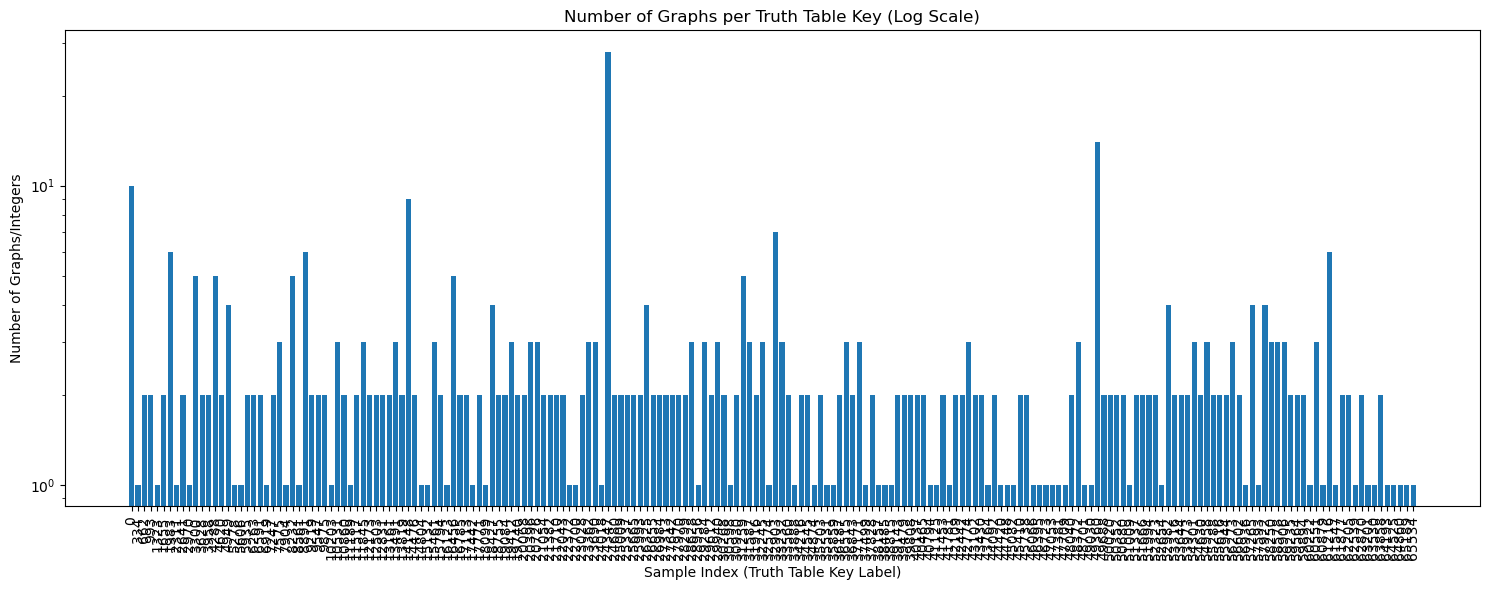

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Extract keys (sorted) and compute the count for each key.
keys = sorted(precomputed_graphs_4_input.keys())
counts = [len(precomputed_graphs_4_input[k]) for k in keys]

# Filter out keys with 0 counts (log scale cannot display zero)
filtered_keys = [k for k, count in zip(keys, counts) if count > 0]
filtered_counts = [count for count in counts if count > 0]

print(f"Number of keys with nonzero counts: {len(filtered_keys)}")

# If there are too many keys, sample a subset for plotting.
max_keys_to_plot = 200  # adjust as needed
if len(filtered_keys) > max_keys_to_plot:
    indices = np.linspace(0, len(filtered_keys) - 1, num=max_keys_to_plot, dtype=int)
    sample_keys = [filtered_keys[i] for i in indices]
    sample_counts = [filtered_counts[i] for i in indices]
else:
    sample_keys = filtered_keys
    sample_counts = filtered_counts

# Use indices for the x-axis, then label the ticks with the corresponding truth table keys.
x = np.arange(len(sample_keys))

plt.figure(figsize=(15, 6))
plt.bar(x, sample_counts, width=0.8)
plt.xlabel("Sample Index (Truth Table Key Label)")
plt.ylabel("Number of Graphs/Integers")
plt.title("Number of Graphs per Truth Table Key (Log Scale)")
plt.yscale('log')

# Set x-tick labels to the actual truth table keys; rotate for clarity if needed.
plt.xticks(x, sample_keys, rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
keys = sorted(precomputed_graphs_4_input.keys())
print("Total number of keys:", len(keys))
print("Minimum key:", keys[0])
print("Maximum key:", keys[-1])
print("First 10 keys:", keys[:10])
print("Last 50 keys:", keys[-100:])


In [ ]:
precomputed_graphs_4_input

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = graphs_library_4_input[65333]

for node, attrs in G.nodes(data=True):
    print(f"Node {node}: {attrs}")
    
pos = nx.spring_layout(G)  # Layout for better visualization

plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=12)
plt.show()  

In [22]:
'''
with open('graphs_library_4_input_4_3_pruned.pkl', 'wb') as f:
    pickle.dump(graphs_library_4_input, f)

In [23]:
'''

with open('precomputed_graphs_4_input_4_3_pruned.pkl', 'wb') as f:
    pickle.dump(precomputed_graphs_4_input, f)

In [ ]:
data = precomputed_graphs_4_input
num_discrete_spaces = len(data)
dimensions_4_input = [len(data[key]) for key in sorted(data.keys())]
dimensions_4_input